# Introduction

Factorization Machines (FM) - is a model used for classification, regression or ranking tasks. It was developed in 2010. It uses latent features of users/items.


Source: Factorization Machine models in PyTorch (https://github.com/rixwew/pytorch-fm)

In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pt_layer import FactorizationMachine, FeaturesEmbedding, FeaturesLinear, MultiLayerPerceptron

# Read the data

In [3]:
ratings = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv",
                          error_bad_lines=False,
                          warn_bad_lines=False)

/tmp/ipykernel_23/3440835061.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ratings = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv",
/tmp/ipykernel_23/3440835061.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ratings = pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv",


# Prepare the dataset

In [4]:
class MovieLensDataset(torch.utils.data.Dataset):
    """
    MovieLens Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    """
    def __init__(self, ratings):
        data = ratings.copy().to_numpy()
        self.items = data[:, :2].astype(np.int32) - 1  # -1 because ID begins from 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.int64)
        self.item_field_idx = np.array((1,), dtype=np.int64)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target = target / 5.
        return target

In [5]:
def get_dataset():
    return MovieLensDataset(ratings)

# Prepare the algorithm  

## The model  

In [6]:
class FactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Factorization Machine.

    Reference:
        S Rendle, Factorization Machines, 2010.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = self.linear(x) + self.fm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

## Early stopper

In [7]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path, lower_is_better=True):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.lower_is_better = lower_is_better
        if self.lower_is_better:
            self.best_accuracy = 1_000_000
        else:
            self.best_accuracy = 0
        self.save_path = save_path

    def is_continuable(self, model, accuracy):
        print(f"ES accuracy: {accuracy}")
        if (self.lower_is_better and accuracy < self.best_accuracy) or\
           (not self.lower_is_better and accuracy > self.best_accuracy) :
            self.best_accuracy = accuracy
            self.trial_counter = 0
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False

## Get the model

In [8]:
def get_model(dataset):
    field_dims = dataset.field_dims
    return FactorizationMachineModel(field_dims, embed_dim=64) 

## Train

In [9]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    av_loss = []
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            loss = total_loss / log_interval
            av_loss.append(loss)
            tk0.set_postfix(loss=loss)
            total_loss = 0
    return np.mean(av_loss)   

## Test/validation

In [10]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return 5.* mean_squared_error(targets, predicts)

# Settings   


Set the device. If GPU available, set it to "cuda:0". Otherwise, set it to "cpu".

In [11]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

Model parameters

In [12]:
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 2048
epochs = 20
model_name = "DeepFM"

# Prepare train, valid & test datasets

In [13]:
dataset = get_dataset()
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Fit the model

In [14]:
model = get_model(dataset).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopper = EarlyStopper(num_trials=5, save_path=f'{model_name}.pt')

In [15]:
metric_values = []
loss_values = []

for epoch_i in range(epochs):
    loss = train(model, optimizer, train_data_loader, criterion, device)
    loss_values.append((epoch_i, loss))
    
    metric_valid = test(model, valid_data_loader, device)
    print('epoch:', epoch_i + 1, 'validation: mae:', metric_valid)
    
    metric_train = test(model, train_data_loader, device)
    print('train mae:', metric_train)
    
    metric_test = test(model, test_data_loader, device)
    print(f'test mae: {metric_test}')
    
    metric_values.append((epoch_i, metric_train, metric_valid, metric_test))
    
    if not early_stopper.is_continuable(model, metric_valid):
        print(f'validation: best mae: {early_stopper.best_accuracy}')
        break

100%|██████████| 977/977 [00:15<00:00, 61.60it/s]


epoch: 1 validation: mae: 0.19150770481323579


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [02:01<00:00, 64.21it/s]


train mae: 0.19164727872597379


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 62.01it/s]


test mae: 0.19198811452839512
ES accuracy: 0.19150770481323579


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 61.75it/s]


epoch: 2 validation: mae: 0.19150545235720132


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [01:59<00:00, 65.29it/s]


train mae: 0.19164509695652954


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 62.65it/s]


test mae: 0.19198592650404303
ES accuracy: 0.19150545235720132


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:16<00:00, 60.86it/s]


epoch: 3 validation: mae: 0.19150545191847837


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [02:00<00:00, 64.59it/s]


train mae: 0.19164509662193965


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:16<00:00, 60.06it/s]


test mae: 0.19198592621337845
ES accuracy: 0.19150545191847837


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:16<00:00, 60.83it/s]


epoch: 4 validation: mae: 0.19150545189245496


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [02:01<00:00, 64.42it/s]


train mae: 0.1916450966029153


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:16<00:00, 60.91it/s]


test mae: 0.1919859261966063
ES accuracy: 0.19150545189245496


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 64.60it/s]


epoch: 5 validation: mae: 0.19150545189861973


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [02:02<00:00, 64.03it/s]


train mae: 0.19164509660186446


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 61.85it/s]


test mae: 0.19198592620024618
ES accuracy: 0.19150545189861973


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 65.60it/s]


epoch: 6 validation: mae: 0.19150545189312337


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [02:00<00:00, 65.05it/s]


train mae: 0.19164509660247434


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:16<00:00, 60.46it/s]


test mae: 0.1919859261959794
ES accuracy: 0.19150545189312337


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 66.23it/s]


epoch: 7 validation: mae: 0.19150545188975082


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [01:58<00:00, 65.71it/s]


train mae: 0.19164509659745066


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 65.28it/s]


test mae: 0.19198592619026655
ES accuracy: 0.19150545188975082


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 63.39it/s]


epoch: 8 validation: mae: 0.19150545189756718


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [01:58<00:00, 65.81it/s]


train mae: 0.1916450966039346


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 66.14it/s]


test mae: 0.19198592619789154
ES accuracy: 0.19150545189756718


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 61.77it/s]


epoch: 9 validation: mae: 0.19150545189635665


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [01:59<00:00, 65.25it/s]


train mae: 0.191645096603825


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 61.76it/s]


test mae: 0.1919859261966128
ES accuracy: 0.19150545189635665


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 67.87it/s]


epoch: 10 validation: mae: 0.1915054518893694


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [01:59<00:00, 65.58it/s]


train mae: 0.1916450965990056


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 62.82it/s]


test mae: 0.19198592619357768
ES accuracy: 0.1915054518893694


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 64.69it/s]


epoch: 11 validation: mae: 0.19150545189302745


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [02:00<00:00, 65.10it/s]


train mae: 0.1916450966040907


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 66.63it/s]


test mae: 0.1919859261972309
ES accuracy: 0.19150545189302745


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 61.77it/s]


epoch: 12 validation: mae: 0.19150545189329476


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [02:00<00:00, 64.79it/s]


train mae: 0.19164509660103185


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 65.39it/s]


test mae: 0.19198592619339094
ES accuracy: 0.19150545189329476


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 63.03it/s]


epoch: 13 validation: mae: 0.19150545189152068


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [01:59<00:00, 65.42it/s]


train mae: 0.19164509659815288


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 66.95it/s]


test mae: 0.19198592619201166
ES accuracy: 0.19150545189152068


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 62.06it/s]


epoch: 14 validation: mae: 0.19150545189960846


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [01:59<00:00, 65.44it/s]


train mae: 0.19164509660325113


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 63.36it/s]


test mae: 0.19198592619568758
ES accuracy: 0.19150545189960846


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:14<00:00, 65.68it/s]


epoch: 15 validation: mae: 0.19150545190917356


  0%|          | 0/7813 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 7813/7813 [01:59<00:00, 65.13it/s]


train mae: 0.1916450966121297


  0%|          | 0/977 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 977/977 [00:15<00:00, 61.53it/s]


test mae: 0.1919859262084743
ES accuracy: 0.19150545190917356
validation: best mae: 0.1915054518893694


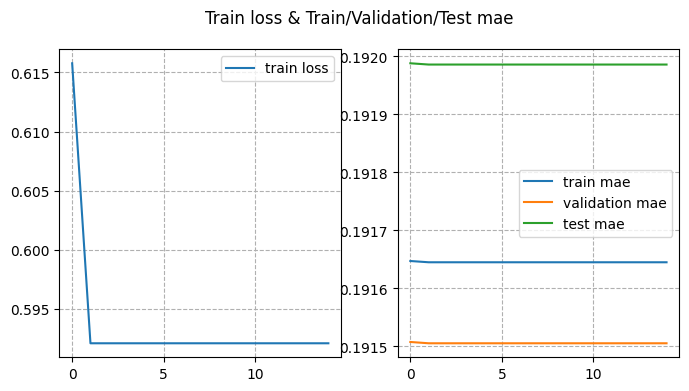

In [16]:
from matplotlib import pyplot as plt
metric_values = np.array(metric_values)
loss_values = [x[1] for x in loss_values]
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(loss_values, label="train loss")
ax[0].legend()
ax[0].grid(linestyle="--",which="major")

ax[1].plot(metric_values[:, 1], label="train mae")
ax[1].plot(metric_values[:, 2], label="validation mae")
ax[1].plot(metric_values[:, 3], label="test mae")
ax[1].legend()
ax[1].grid(linestyle="--",which="major")
plt.suptitle("Train loss & Train/Validation/Test mae")
plt.show()